[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/open-atmos/PyPartMC/blob/main/examples/additive_coag_comparison.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyPartMC/blob/main/examples/additive_coag_comparison.ipynb)    
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyPartMC.git/main?urlpath=lab/tree/examples/additive_coag_comparison.ipynb)

In [8]:
# This file is a part of PyPartMC licensed under the GNU General Public License v3
# Copyright (C) 2023 University of Illinois Urbana-Champaign
# Authors:
#  - https://github.com/compdyn/partmc/graphs/contributors
#  - https://github.com/open-atmos/PyPartMC/graphs/contributors

In [9]:
import sys

if "google.colab" in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyPartMC')

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import show_plot
import PyPartMC as ppmc
import PySDM as pysdm
from PySDM import environments
from PySDM.initialisation import spectra
from PySDM.dynamics.collisions import collision_kernels
from PySDM import products

In [11]:
N_PART = 100000
VOLUME_M3 = 1.
DT_SEC = 1.
T_MAX_SEC = 600
NUM_CONC_PER_M3 = 1e9
DIAM_AT_MEAN_VOL_M = 2e-5
ADDITIVE_KERNEL_COEFF = 1000  # TODO: not used by PartMC
AMBIENT_T_K = 288
AMBIENT_P_Pa = 1e5
AMBIENT_RH = 0.999

In [12]:
radius_bins_edges=np.logspace(-7, -3, base=10) * pysdm.physics.si.m

builder = pysdm.Builder(
    N_PART,
    backend=pysdm.backends.CPU(),
    environment=environments.Box(dt=DT_SEC * pysdm.physics.si.s, dv=VOLUME_M3 * pysdm.physics.si.m**3)
)
trivia = builder.formulae.trivia
spectrum = spectra.Exponential(
    norm_factor=NUM_CONC_PER_M3 / pysdm.physics.si.m**3,
    scale=trivia.volume(radius=DIAM_AT_MEAN_VOL_M / 2 * pysdm.physics.si.m)
)
builder.add_dynamic(pysdm.dynamics.Coalescence(
    collision_kernel=collision_kernels.Golovin(b=ADDITIVE_KERNEL_COEFF)
))
particulator = builder.build(
    attributes=builder.particulator.environment.init_attributes(
        spectral_discretisation=pysdm.initialisation.sampling.spectral_sampling.Logarithmic(
            spectrum,
        )
    ),
    products=(
        products.ParticleSizeSpectrumPerVolume(
            radius_bins_edges=radius_bins_edges,
            name='spectrum'
        ),
    )
)

particulator.environment["rhod"] = 1. # TODO!
pysdm_output = {}
for minute in range(int(T_MAX_SEC // 60)):
    if minute != 0:
        particulator.run(int(60 // DT_SEC))
    pysdm_output[minute] = particulator.products['spectrum'].get()

/Users/emmaware/Library/Python/3.9/lib/python/site-packages/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(


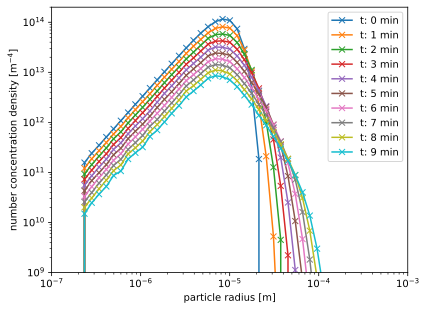

HTML(value="<a href='./tmpdst330m2.pdf' target='_blank'>./tmpdst330m2.pdf</a><br>")

In [13]:
for minute in pysdm_output.keys():
    plt.plot(
        (radius_bins_edges[1:] + radius_bins_edges[:-1]) / 2,
        pysdm_output[minute],
        label=f"t: {minute} min",
        marker='x'
    )
plt.xscale("log")
plt.yscale("log")
plt.xlabel("particle radius [m]")
plt.ylabel("number concentration density [m$^{-4}$]")
plt.legend()
plt.xlim([1e-7,1e-3])
plt.ylim([1e9,2e14])
show_plot()

In [14]:
gas_data = ppmc.GasData(("H2SO4","HNO3","HCl","NH3","NO","NO2"))

In [15]:
env_state = ppmc.EnvState(
    {
        "rel_humidity": AMBIENT_RH,
        "latitude": 40,
        "longitude": 0,
        "altitude": 0 * ppmc.si.m,
        "start_time": 0 * ppmc.si.s,
        "start_day": 1,
    }
)

In [16]:
aero_data = ppmc.AeroData(
    (
        {"H2O": [1000 * ppmc.si.kg / ppmc.si.m**3, 0, 18.0 * ppmc.si.g / ppmc.si.mol, 0.00]},
    )
)

In [17]:
gas_state = ppmc.GasState(gas_data)

In [18]:
times = [0 * ppmc.si.s]
back_gas = [{"time": times},
            {"rate": [0 / ppmc.si.s]},
            {"NO": [0.0E+00]},
           ]

gas_emit_times = [0]

gas_emit_rates = np.ones(len(gas_emit_times))

emit_gas = [
    {"time": gas_emit_times},
    {"rate": list(gas_emit_rates)},
    {"NO": [0]},
]

AERO_DIST_BACKGROUND = {
    "back_small": {
        "mass_frac": [{"H2O": [1]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 0 / ppmc.si.m**3,
        "geom_mean_diam": 0.02 * ppmc.si.um,
        "log10_geom_std_dev": 0.161,
    },
}

AERO_DIST_EMIT = {
    "gasoline": {
        "mass_frac": [{"H2O": [1.0]}],
        "diam_type": "geometric",
        "mode_type": "log_normal",
        "num_conc": 0 / ppmc.si.m**3,
        "geom_mean_diam": 5e-8 * ppmc.si.m,
        "log10_geom_std_dev": 0.24,
    },
}

In [19]:
time_timeseries = [0]
pressure_timeseries = [AMBIENT_P_Pa * ppmc.si.Pa]
temp_timeseries = [AMBIENT_T_K * ppmc.si.K]
height_timeseries = [1000]

In [20]:
scenario = ppmc.Scenario(
    gas_data,
    aero_data,
    {
        "temp_profile": [{"time": time_timeseries}, {"temp": temp_timeseries}],
        "pressure_profile": [
            {"time": time_timeseries},
            {"pressure": pressure_timeseries},
        ],
        "height_profile": [{"time": time_timeseries}, {"height": height_timeseries}],
        "gas_emissions": emit_gas,
        "gas_background": back_gas,
        "aero_emissions": [
            {"time": [0 * ppmc.si.s]},
            {"rate": [0 / ppmc.si.s]},
            {"dist": [[AERO_DIST_EMIT]]},
        ],
        "aero_background": [
            {"time": [0 * ppmc.si.s]},
            {"rate": [0 / ppmc.si.s]},
            {"dist": [[AERO_DIST_BACKGROUND]]},
        ],
        "loss_function": "none",
    },
)

In [21]:
T_INITIAL = 0.0
scenario.init_env_state(env_state, T_INITIAL)

In [22]:
AERO_DIST_INIT = [
    {
        "init1": {
            "mass_frac": [{"H2O": [1]}],
            "diam_type": "geometric",
            "mode_type": "exp",
            "num_conc": NUM_CONC_PER_M3 / ppmc.si.m**3,
            "diam_at_mean_vol": DIAM_AT_MEAN_VOL_M * ppmc.si.m,
        },
    }
]

aero_dist_init = ppmc.AeroDist(aero_data, AERO_DIST_INIT)

In [23]:
run_part_opt = ppmc.RunPartOpt(
    {
        "output_prefix": 'additive',
        "do_coagulation": True,
        "coag_kernel": "additive",
        "t_max": T_MAX_SEC * ppmc.si.s,
        "del_t": DT_SEC * ppmc.si.s,
    }
)

aero_state = ppmc.AeroState(aero_data, N_PART, "flat")
aero_state.dist_sample(aero_dist_init)

99395

In [24]:
camp_core = ppmc.CampCore()
photolysis = ppmc.Photolysis()

In [25]:
N_STEPS = int(run_part_opt.t_max / run_part_opt.del_t)
num_conc = np.zeros(N_STEPS + 1)
num_conc[0] = aero_state.total_num_conc
mass_conc = np.zeros(N_STEPS + 1)
mass_conc[0] = aero_state.total_mass_conc
time = np.zeros(N_STEPS + 1)
gas_mix_rat = np.zeros((N_STEPS + 1, gas_state.n_spec))
gas_mix_rat[0, :] = gas_state.mix_rats

height = np.zeros((N_STEPS + 1))
temperature = np.zeros((N_STEPS + 1))
rh = np.zeros((N_STEPS + 1))

height[0] = env_state.height
temperature[0] = env_state.temp
rh[0] = env_state.rh

diam_grid = ppmc.BinGrid(160, "log", 1e-8, 1e-3)
dists = []
diameters = aero_state.diameters()
num_concs = aero_state.num_concs
masses = aero_state.masses()
mass_concs = np.array(num_concs) * np.array(masses)
dists_mass = []
dists.append(ppmc.histogram_1d(diam_grid, diameters, num_concs))
dists_mass.append(ppmc.histogram_1d(diam_grid, diameters, mass_concs))

for i_time in range(1,N_STEPS + 1):
    ppmc.run_part_timestep(
        scenario,
        env_state,
        aero_data,
        aero_state,
        gas_data,
        gas_state,
        run_part_opt,
        camp_core,
        photolysis,
        i_time,
        T_INITIAL,
    )
    num_conc[i_time] = aero_state.total_num_conc
    mass_conc[i_time] = aero_state.total_mass_conc
    time[i_time] = env_state.elapsed_time
    gas_mix_rat[i_time, :] = gas_state.mix_rats
    height[i_time] = env_state.height
    temperature[i_time] = env_state.temp
    rh[i_time] = env_state.rh
    if np.mod(i_time * run_part_opt.del_t, 60.0) == 0:
        diameters = aero_state.diameters()
        num_concs = aero_state.num_concs
        masses = aero_state.masses()
        mass_concs = np.array(num_concs) * np.array(masses)
        dists.append(ppmc.histogram_1d(diam_grid, diameters, num_concs))
        dists_mass.append(ppmc.histogram_1d(diam_grid, diameters, mass_concs))

In [26]:
plt.rcParams.update({'font.size': 9})
plt.rcParams.update({'figure.figsize': (7.08,4.5)})
plt.rcParams.update({"axes.grid" : True})

In [27]:
def set_tickmarks(axes, n_ticks):
    ylims = axes.get_ylim()
    if np.log10(ylims[0]) > 1:
        val = -int(np.ceil(np.abs(np.log10(ylims[0])))) + 1
    else:
        val = int(np.ceil(np.abs(np.log10(ylims[0])))) + 1     
    ymin = round(ylims[0] - .1 * ylims[0], val)
    ymax = round(ylims[1] + .1 * ylims[1], val)
    plt.ylim([ymin, ymax])
    plt.yticks(np.linspace(ymin, ymax, n_ticks))

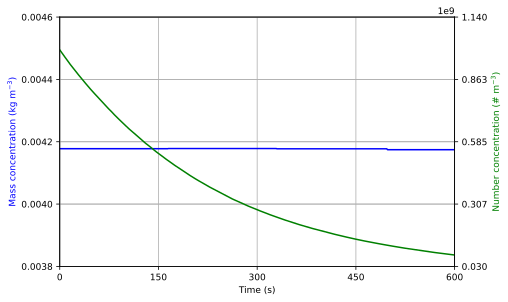

HTML(value="<a href='./tmpm1sdd530.pdf' target='_blank'>./tmpm1sdd530.pdf</a><br>")

In [28]:
plt.plot(time, mass_conc, "b", label="mass conc")
plt.ylabel("Mass concentration (kg m$^{-3}$)", color='b')
plt.xlabel("Time (s)")
set_tickmarks(plt.gca(), 5)
plt.twinx()
plt.plot(time, num_conc, "g", label="num conc")
plt.xticks(np.linspace(0, time[-1], 5))
plt.xlim([time[0],time[-1]])
set_tickmarks(plt.gca(), 5)
plt.ylabel(r"Number concentration ($\#$ m$^{-3}$)", color='g')
show_plot()

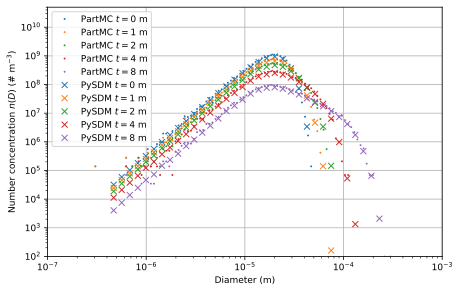

HTML(value="<a href='./tmp9012bo4q.pdf' target='_blank'>./tmp9012bo4q.pdf</a><br>")

In [29]:
cs = []
t = [0,1,2,4,8]
for i_time, t_min in enumerate(t):
    p = plt.plot(diam_grid.centers, dists[t_min],'o',label=f'PartMC $t = {t_min}$ m',
           ms=1)
    cs.append(p[0].get_color())
    
for i_time,minute in enumerate(t):
    plt.plot((radius_bins_edges[1:] + radius_bins_edges[:-1]),
        pysdm_output[minute] * np.log(10) * 2*(radius_bins_edges[1:] - radius_bins_edges[:-1]),
             'x', label=f'PySDM $t = {minute}$ m', c='%s' %cs[i_time])
plt.xscale("log")
plt.xlabel("Diameter (m)")
plt.ylabel(r"Number concentration $n(D)$ ($\#$ m$^{-3}$)")
plt.yscale('log')
plt.xlim([1e-7,1e-3])
plt.ylim([1e2,5e10])
plt.legend(loc=2)
show_plot()

In [30]:
import urllib
BASE_URL = (
    'https://raw.githubusercontent.com/emmacware/Droplets.jl/refs/heads/main/' # replace main with commit id for previous commit
)
for path in (
    'src/Droplets.jl', 'Examples/DSDvis.jl'
):
    print(path)
    with open('Droplets.jl-' + path.replace('/','-'), 'w', encoding='utf-8') as fout:
        with urllib.request.urlopen(BASE_URL + path) as fin:
            fout.write(fin.read().decode('utf-8'))

src/Droplets.jl
Examples/DSDvis.jl


In [34]:
SETUP = {
    "n_0": NUM_CONC_PER_M3,
    "Ns": N_PART,
    "V": VOLUME_M3,
    "dt": DT_SEC,
    "t_max": T_MAX_SEC,
    "d_mean": DIAM_AT_MEAN_VOL_M,
    "b": ADDITIVE_KERNEL_COEFF,
    "num_bins" : len(radius_bins_edges),
    "radius_bins_log_low":(1e-7), 
    "radius_bins_log_high":(1e-3),
    "smooth": False,
    "smooth_scope": 2,
    "init_random_seed": 30,
    "coag_threading": "Parallel()",
    "output_steps": [0,60,120,240,480],
    "init_method": "init_logarithmic",
    "binning_method": "number_concentration",
}

import json
import subprocess
with open('setup.json', 'w', encoding='UTF-8') as f:
    json.dump(SETUP, f)

In [37]:
%%writefile to_vtk.jl
using Package
Pkg.add(["Combinatorics","Distributions","Random","JSON","DelimitedFiles"])
using Random
using Combinatorics
using Distributions
include("Droplets.jl-src-Droplets.jl")
using .Droplets
include("DSDvis.jl")
include("testfunctions.jl")
using DelimitedFiles

    
FT = Float64
setup = JSON.parsefile("./setup.json")



Ns::Int = setup["Ns"]
scale = Ns * (Ns - 1) / 2 / (Ns / 2)
FT = Float64
num_bins::Int = setup["num_bins"]
radius_bins_edges = 10 .^ range(log10(setup["radius_bins_log_low"]), log10("radius_bins_log_high"), length=num_bins) 
R0 = FT(setup["d_mean"])/2


coagsettings = coag_settings{FT}(Ns=Ns,scale=scale,Δt=setup["dt"],ΔV=setup["V"],
        goloving_kernel_coeff=FT(setup["b"]), n0=FT(setup["n_0"]),R0=R0)

runsettings=run_settings{FT}(num_bins=num_bins,radius_bins_edges=radius_bins_edges,
        smooth=setup["smooth"],coag_threading=eval(Meta.parse(setup["coag_threading"])),
        output_steps=setup["output_steps"],init_method=eval(Meta.parse(setup["init_method"])))

ξ, R, X = runsettings.init_method(coagsettings)
I = collect(1:Ns)
drops = droplets_allocations(ξ, R, X, I, zeros(FT, div(Ns, 2)), zeros(FT, div(Ns, 2)))
bin,timing = coag_runtime(1,drops,coagsettings,runsettings)


file_path = "Droplets_run.csv"
dir_path = dirname(file_path)
if !isdir(dir_path)
    mkpath(dir_path)
end

writedlm(file_path, bin, ',')

println("output written to $file_path")

Overwriting to_vtk.jl


In [36]:
import os
import subprocess
subprocess.run(["julia", "to_vtk.jl"], check=True)


The latest version of Julia in the `release` channel is 1.11.1+0.aarch64.apple.darwin14. You currently have `1.10.4+0.aarch64.apple.darwin14` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.11.1+0.aarch64.apple.darwin14 and update the `release` channel to that version.
ERROR: LoadError: SystemError: opening file "/Users/emmaware/PyPartMC/examples/SDfunc/constants.jl": No such file or directory
Stacktrace:
  [1] systemerror(p::String, errno::Int32; extrainfo::Nothing)
    @ Base ./error.jl:176
  [2] systemerror
    @ ./error.jl:175 [inlined]
  [3] open(fname::String; lock::Bool, read::Nothing, write::Nothing, create::Nothing, truncate::Nothing, append::Nothing)
    @ Base ./iostream.jl:293
  [4] open
    @ ./iostream.jl:275 [inlined]
  [5] open(f::Base.var"#433#434"{String}, args::String; kwargs::@Kwargs{})
    @ Base ./io.jl:394
  [6] open
    @ ./io.jl:393 [inlined]
  [7] read
    @ ./io.jl:486 [inlined]
  [8] _include(mapexpr::Function, mod::Module, _path

CalledProcessError: Command '['julia', 'to_vtk.jl']' returned non-zero exit status 1.

In [ ]:
Droplets = pd.read_csv('Droplets_run.csv', header=None)

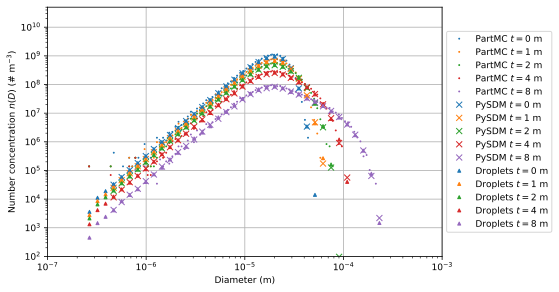

HTML(value="<a href='./tmpxvzdbk9n.pdf' target='_blank'>./tmpxvzdbk9n.pdf</a><br>")

In [ ]:
cs = []
t = [0,1,2,4,8]
for i_time, t_min in enumerate(t):
    p = plt.plot(diam_grid.centers, dists[t_min],'o',label=f'PartMC $t = {t_min}$ m',
           ms=1)
    cs.append(p[0].get_color())
    
for i_time,minute in enumerate(t):
    plt.plot((radius_bins_edges[1:] + radius_bins_edges[:-1]),
        pysdm_output[minute] * np.log(10) * 2*(radius_bins_edges[1:] - radius_bins_edges[:-1]),
             'x', label=f'PySDM $t = {minute}$ m', c='%s' %cs[i_time])
    
min = [0,1,2,4,8]
for i_time,minute in enumerate(min):
    plt.plot((radius_bins_edges[1:] + radius_bins_edges[:-1]),Droplets[i_time]* np.log(10) * 2*(radius_bins_edges[1:] - radius_bins_edges[:-1]), '^', label=f'Droplets $t = {min[i_time]}$ m',ms=3,
    c='%s' %cs[i_time])
# for i_time,minute in enumerate(t):
#     plt.plot()     
plt.xscale("log")
plt.xlabel("Diameter (m)")
plt.ylabel(r"Number concentration $n(D)$ ($\#$ m$^{-3}$)")
plt.yscale('log')
plt.xlim([1e-7,1e-3])
plt.ylim([1e2,5e10])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('units.pdf', bbox_inches='tight')

show_plot()